In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
# from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20580 files belonging to 120 classes.


In [4]:
class_names = dataset.class_names
class_names

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 94  90  99  93  61  29  38 101  13 109  14  30  59   1  32  12  97  39
  54  12   4  92  52  70  42  31  28 119  47  48 116  99]


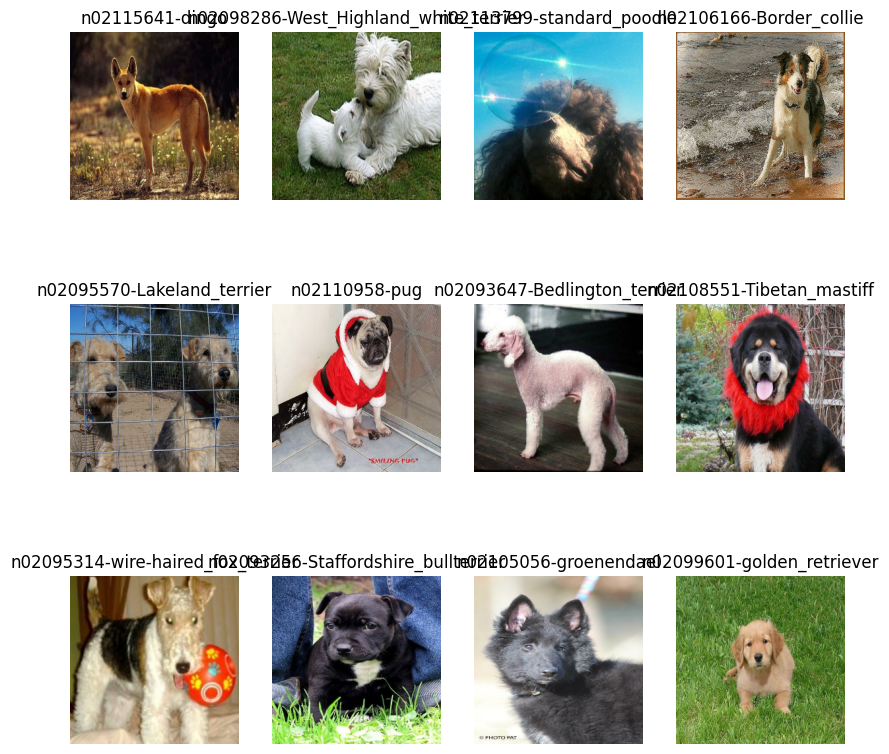

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

644

In [8]:
train_size = 0.8
len(dataset)*train_size

515.2

In [9]:
train_ds = dataset.take(515)
len(train_ds)

515

In [10]:
test_ds = dataset.skip(515)
len(test_ds)

129

In [11]:
val_size=0.1
len(dataset)*val_size

64.4

In [12]:
val_ds = test_ds.take(64)
len(val_ds)

64

In [13]:
test_ds = test_ds.skip(64)
len(test_ds)

65

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

515

In [17]:
len(val_ds)

64

In [18]:
len(test_ds)

65

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# def py_function_wrapper(x):
#     # Your NumPy operation here
#     result = np.your_numpy_operation(x)
#     return tf.convert_to_tensor(result, dtype=tf.float32)  # Adjust the dtype as needed

# train_ds = train_ds.map(
#     lambda x, y: (tf.py_function(py_function_wrapper, [x], tf.float32), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 120

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=2,
)

Epoch 1/2
515/515 [==============================] - 444s 817ms/step - loss: 4.7853 - accuracy: 0.0108 - val_loss: 4.7702 - val_accuracy: 0.0137
Epoch 2/2
515/515 [==============================] - 404s 785ms/step - loss: 4.6650 - accuracy: 0.0180 - val_loss: 4.6221 - val_accuracy: 0.0186


In [28]:
scores = model.evaluate(test_ds)

65/65 [==============================] - 34s 180ms/step - loss: 4.6112 - accuracy: 0.0245


In [29]:
scores

[4.611222743988037, 0.02451923117041588]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 2, 'steps': 515}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['loss'][:5] # show loss for first 5 epochs

[4.785346984863281, 4.664985656738281]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [36]:
print(len(range(EPOCHS)))
print(len(acc))
print(len(val_acc))
print(len(loss))
print(len(val_loss))


50
2
2
2
2


first image to predict
actual label: n02091635-otterhound
predicted label: n02111277-Newfoundland


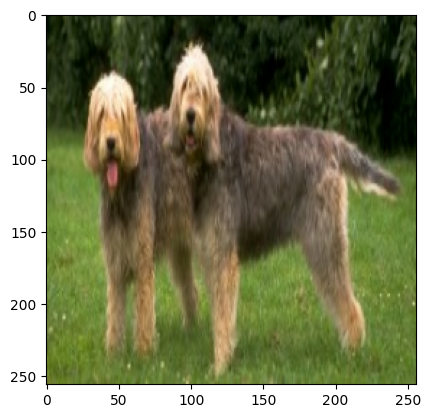

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

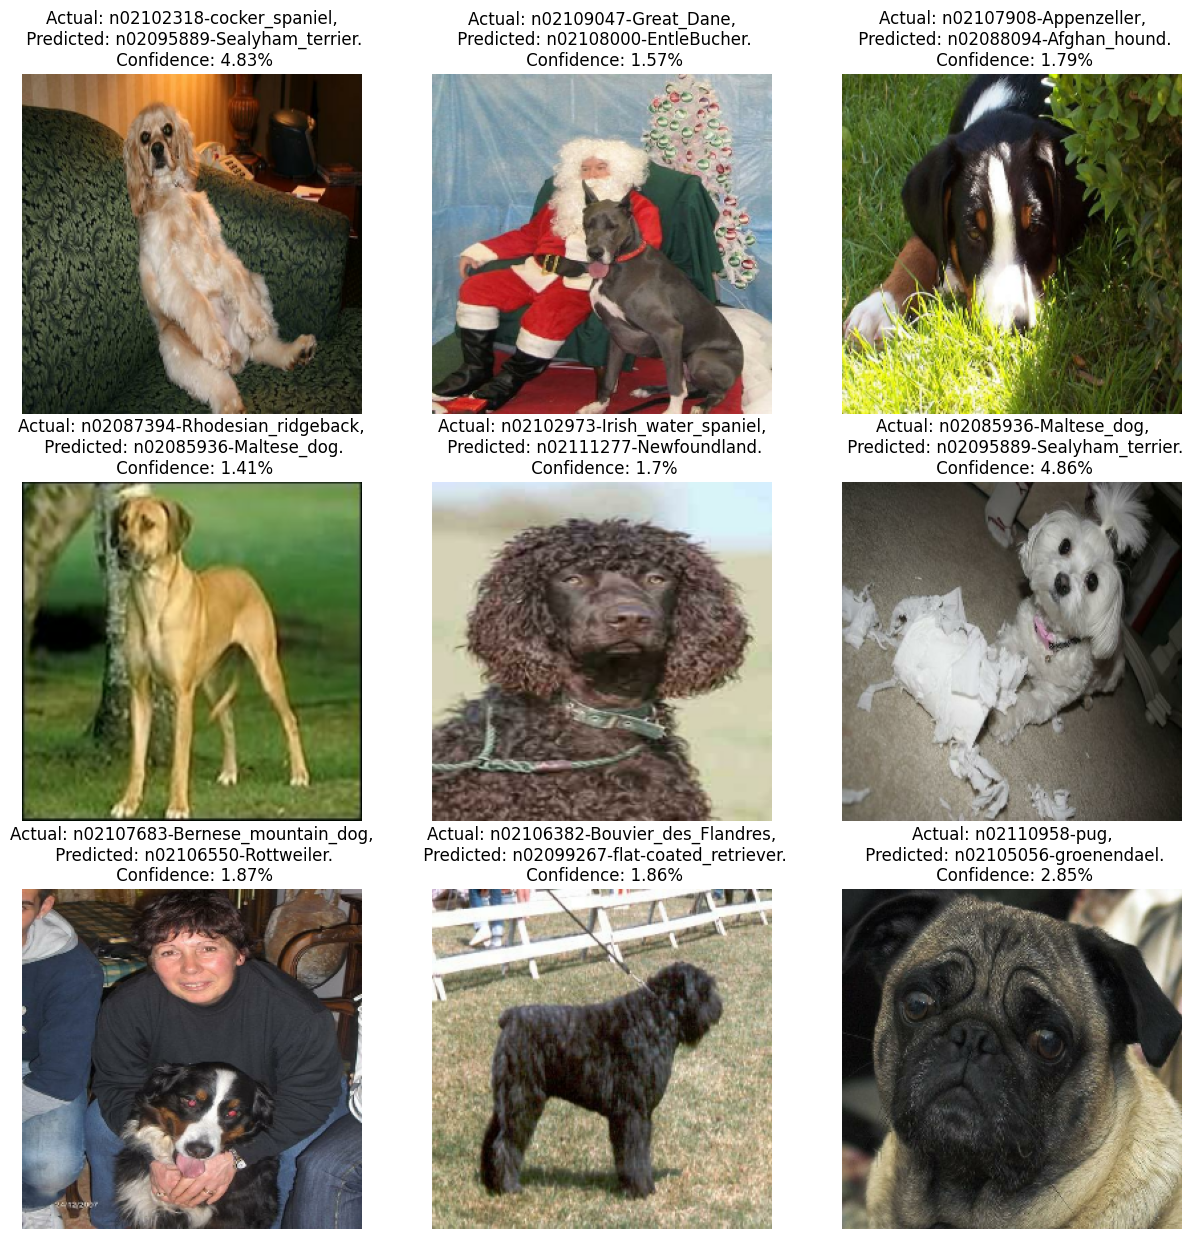

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [49]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [52]:
model.save("dogs.h5")